In [69]:
import pandas as pd

#데이터셋 불러오기
df = pd.read_csv("netflix_reviews.csv")

# 데이터셋 크기와 열 정보 출력
print(f"Shape of the dataset: {df.shape}")
print(f"Columns in the dataset: {df.columns}")

Shape of the dataset: (117040, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [70]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    pattern = r'[^a-zA-Z가-힣]'
    text = re.sub(pattern=pattern, repl=' ', string=text) # 특수문자, 숫자제거
    return text

# 불필요한 열 제거
df = df[['content', 'score']]

# 리뷰 텍스트 정제
df['content'] = df['content'].apply(preprocess_text)

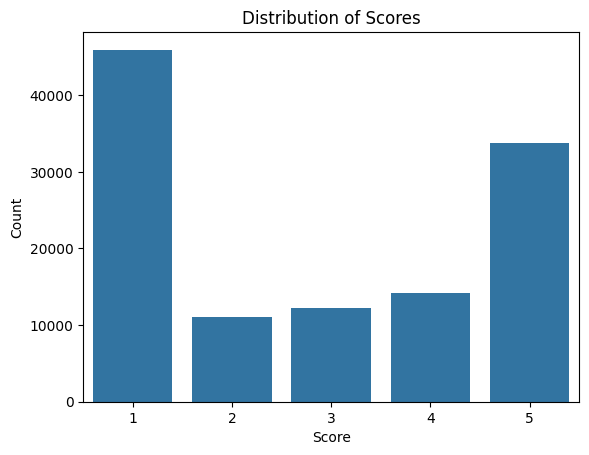

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# 리뷰 점수 분포 확인
sns.countplot(x='score', data=df)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [12]:
!pip install torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [72]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator

reviews = df['content']
ratings = df['score']


# 훈련, 테스트 데이터 분할
train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(reviews, ratings, test_size=0.3, random_state=42)

# 인덱스 초기화
train_reviews.reset_index(drop=True, inplace=True)
train_ratings.reset_index(drop=True, inplace=True)
test_reviews.reset_index(drop=True, inplace=True)
test_ratings.reset_index(drop=True, inplace=True)

# 단어 사전 구축을 위한 함수
def build_vocab(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    vocab = build_vocab_from_iterator(tokenized_reviews, specials=["<pad>", "<unk>"])
    vocab.set_default_index(vocab["<unk>"])  # 알 수 없는 단어 처리
    return vocab

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review), torch.tensor(rating)

def collate_fn(batch):
    reviews, ratings = zip(*batch)  # 배치에서 리뷰와 레이팅 분리
    reviews_padded = pad_sequence(reviews, batch_first=True)  # 리뷰를 패딩
    ratings_tensor = torch.tensor(ratings)  # 레이팅을 텐서로 변환
    return reviews_padded, ratings_tensor  # 패딩된 리뷰와 레이팅 반환

# 단어 사전 생성
vocab = build_vocab(train_reviews)

# 파이프라인 정의
def text_pipeline(text):
    tokenized = word_tokenize(text)  # 토큰화
    return torch.tensor([vocab[token] for token in tokenized], dtype=torch.long)  # 텐서를 LongTensor로 변환

class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]


label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 데이터셋 정의
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [73]:
text_pipeline.fit(df['content'].values)

AttributeError: 'function' object has no attribute 'fit'

In [8]:
!pip install keras

In [74]:
# 모델 정의
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True, padding_idx=0)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.5)
    self.fc = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Dropout(0.5),  # 드롭아웃 추가
    nn.Linear(128, output_dim)
)

  def forward(self, text):
    embedded = self.embedding(text)
    output, (hidden, cell) = self.lstm(embedded.unsqueeze(1))  # 배치 사이즈에 맞게 차원 추가
    return self.fc(hidden[-1].view(hidden.size(1), -1))  # hidden의 차원 변형

# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 예측할 점수 개수

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 모델 학습 과정 정의
def train_model(model, train_dataloader, optimizer, criterion, epochs=10):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(epochs):
        total_loss = 0

        for batch in train_dataloader:
            reviews, ratings = batch  # 배치 데이터
            optimizer.zero_grad()  # 옵티마이저 초기화

            # 모델의 출력
            output = model(reviews)

            # 손실 계산 및 역전파
            loss = criterion(output, ratings)
            loss.backward()  # 그라디언트 계산
            optimizer.step()  # 옵티마이저를 통한 파라미터 업데이트

            total_loss += loss.item()

# 모델 학습
train_model(model, train_dataloader, optimizer, criterion, epochs=10)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

In [32]:
# 예측 함수
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        tensor_review = torch.tensor(text_pipeline(review)).unsqueeze(0)  # 리뷰를 텐서로 변환 및 배치 차원 추가
        lengths = [tensor_review.size(1)]  # 리뷰 길이
        output = model(tensor_review)  # 모델의 출력
        prediction = output.argmax(1).item()
        return prediction  # 예측된 레이블 반환

# 새로운 리뷰에 대한 예측
new_review = "This app is great but has some bugs."
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

Predicted Score: 0


<ipython-input-32-d9b04faac77f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_review = torch.tensor(text_pipeline(review)).unsqueeze(0)  # 리뷰를 텐서로 변환 및 배치 차원 추가


In [67]:
def evaluate_model(model, test_reviews, test_ratings):
    model.eval()  # 모델을 평가 모드로 전환
    correct_predictions = 0  # 맞춘 예측 수
    total_predictions = len(test_ratings)  # 총 예측 수

    with torch.no_grad():
        for review, actual_rating in zip(test_reviews, test_ratings):
            tokenized_review = text_pipeline(review)  # 리뷰를 텍스트 파이프라인으로 변환

            # 토큰화 결과가 비어있는지 확인 (크기 확인)
            if isinstance(tokenized_review, torch.Tensor) and tokenized_review.numel() == 0:
                continue  # 비어있다면 다음 리뷰로 넘어감

            tensor_review = torch.tensor(tokenized_review).unsqueeze(0)  # 리뷰를 텐서로 변환 및 배치 차원 추가

            output = model(tensor_review)  # 모델의 출력
            prediction = output.argmax(1).item()  # 예측된 레이블

            if prediction == actual_rating:  # 예측이 실제 레이블과 같으면
                correct_predictions += 1  # 맞춘 예측 수 증가

    accuracy = correct_predictions / total_predictions * 100  # 정확도 계산
    return accuracy

# 모델 평가
accuracy = evaluate_model(model, test_reviews, test_ratings)
print(f'Accuracy: {accuracy:.2f}%')

<ipython-input-67-d23901255b69>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_review = torch.tensor(tokenized_review).unsqueeze(0)  # 리뷰를 텐서로 변환 및 배치 차원 추가


Accuracy: 5.90%


In [78]:
# 모델 학습 함수
def train(model, loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for reviews, labels in loader:
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.4f}')


# 모델 평가 함수
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for reviews, labels in loader:
            outputs = model(reviews)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 모델 학습
train(model, train_dataloader, criterion, optimizer)

# 모델 평가
accuracy = evaluate(model, test_dataloader)
print(f'Accuracy: {accuracy:.4f}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 1/5, Loss: 1.3039


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 2/5, Loss: 1.2955


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 3/5, Loss: 1.2887


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 4/5, Loss: 1.2833


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Epoch 5/5, Loss: 1.2772


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourc

Accuracy: 0.5382


<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(review), torch.tensor(rating)
<ipython-input-72-b54653f570b4>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTe

In [79]:
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5382
